Тестовое задание для компании OsmoViev

In [16]:
import os
import shutil
import random

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms




In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# код для загрузки данных
# DATA_DIR = '/content/drive/MyDrive/osmoviev_test/'
# GEORGES_CSV = f"{DATA_DIR}/georges.csv"
# NON_GEORGES_CSV = f"{DATA_DIR}/non_georges.csv"

# SAVE_DIR = '/content/drive/MyDrive/osmoviev_test/'
# GEORGES_SAVE_PATH = f"{SAVE_DIR}/train/georges"
# NON_GEORGES_SAVE_PATH = f"{SAVE_DIR}/train/non_georges"

# # скачиваем файлы
# !wget --random-wait -i "{GEORGES_CSV}" -P "{GEORGES_SAVE_PATH}"
# !wget --random-wait -i "{NON_GEORGES_CSV}" -P "{NON_GEORGES_SAVE_PATH}"

In [19]:
BASE_DATA_PATH = '/content/drive/MyDrive/osmoviev_test/train'

georges_path = os.path.join(BASE_DATA_PATH, 'georges')
non_georges_path = os.path.join(BASE_DATA_PATH, 'non_georges')

num_georges = len(os.listdir(georges_path))
num_non_georges = len(os.listdir(non_georges_path))

print(f"Всего изображений 'Георгиев': {num_georges}")
print(f"Всего изображений 'не Георгиев': {num_non_georges}")

Всего изображений 'Георгиев': 1373
Всего изображений 'не Георгиев': 1724


In [20]:
SOURCE_PATH = '/content/drive/MyDrive/osmoviev_test/'
TRAIN_PATH = os.path.join(SOURCE_PATH, 'train')
VAL_PATH = os.path.join(SOURCE_PATH, 'val')

os.makedirs(os.path.join(VAL_PATH, 'georges'), exist_ok=True)
os.makedirs(os.path.join(VAL_PATH, 'non_georges'), exist_ok=True)

In [21]:
def split_data(class_name, split_ratio=0.2):
  """Переносит файлы в валидационную выборку"""
  source_dir = os.path.join(TRAIN_PATH, class_name)
  val_dir = os.path.join(VAL_PATH, class_name)

  files = os.listdir(source_dir)
  random.shuffle(files)

  split_point = int(len(files) * split_ratio)
  files_to_move = files[:split_point]

  for file_name in files_to_move:
      shutil.move(os.path.join(source_dir, file_name), os.path.join(val_dir, file_name))
  print(f"Перемещенно {len(files_to_move)} файлов для класса '{class_name}' в валидационную выборку")

split_data('georges')
split_data('non_georges')

Перемещенно 274 файлов для класса 'georges' в валидационную выборку
Перемещенно 344 файлов для класса 'non_georges' в валидационную выборку


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def show_random_images(class_name, split='train', n=5):
    """Визуализация случайных изображений из определенного класса"""

    class_path = os.path.join(SOURCE_PATH, split, class_name)
    if not os.path.exists(class_path):
        print(f"Папка не найдена: {class_path}")
        return

    random_images = random.sample(os.listdir(class_path), n)

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Случайные изображения класса '{class_name}'", fontsize=16)

    for i, img_name in enumerate(random_images):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path)

            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis('off')
        except Exception as e:
            print(f"Не удалось открыть изображение {img_path}: {e}")

    plt.show()

show_random_images('georges', split='train', n=5)
show_random_images('non_georges', split='train', n=5)

Выводы по анализу изображений

1. Большое разнообразие стилей в первом классе, что усложняет задачу, т.к. модель не сможет полагаться на простые текстуры или цвета
2. Святой Георгий расположен совершенно по-разному на каждом изображении. Он может находиться в любой позе, быть отдален или максимально приближен
3. На изображениях может отсутствовать конь / копье / иные аттрибуты для определения Святого Георгия
4. В данных есть фрески, где Георгий занимает малую часть изображения (около 10%). А так-же картины, где весь акцент смещен на иной объект. Модель в данном случае может решить, что объект который занимает бОльшую часть изображения - является признаком класса


Промежуточные мысли

1. Нужна сильаня аугментация, чтобы модель была инварианта к разным стилям изображения (к примеру - ColorJitter). В особенности RandomResizedCrop, чтобы учить модель распознавать отдельные участки изображений
2. Сверточные классификаторы (ResNet) могут цепляться за фон или неважные детали. Стоит смотреть в сторону трансформерных архитектур. Однако, 2500 данных (на класс) может не хватить для обучения того же ViT.
3. Наличие таких примеров, как фреска, где Георгий занимает лишь малую часть изображения - скорее всего будет классифицировано как ложноотрицательное. В данном случае в качестве лосса стоит взять FocalLoss
4. После обучения модели стоит использовать Grad-CAM (или иные) чтобы посмотреть, на чем фокусирует свое внимание модель во время обучения. Это поможет в дальнейшем чтобы понять, насколько модель поняла общие паттерны (в особенности - при обучении трансформера на малом кол-ве данных)

In [24]:
class GeorgesDataset(Dataset):
    """Кастомный класс Dataset для загрузки изображений"""
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Загрузка путей к файлам и меток для класса 'georges'
        georges_dir = os.path.join(data_dir, 'georges')
        if os.path.exists(georges_dir):
            for img_file in os.listdir(georges_dir):
                self.image_files.append(os.path.join(georges_dir, img_file))
                self.labels.append(1)

        # Загрузка путей к файлам и меток для класса 'non_georges'
        non_georges_dir = os.path.join(data_dir, 'non_georges')
        if os.path.exists(non_georges_dir):
            for img_file in os.listdir(non_georges_dir):
                self.image_files.append(os.path.join(non_georges_dir, img_file))
                self.labels.append(0)


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [25]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': GeorgesDataset(os.path.join(SOURCE_PATH, 'train'), data_transforms['train']),
    'val': GeorgesDataset(os.path.join(SOURCE_PATH, 'val'), data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True, num_workers=4, pin_memory=True),
    'val': DataLoader(image_datasets['val'], batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = ['non_georges', 'georges']

print(dataset_sizes)

{'train': 2479, 'val': 3568}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


В качестве модели берем предобученный ViT на ImageNet

In [26]:
model = models.vit_b_16(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.heads.head.in_features
model.heads.head = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)


In [27]:
import os
import pandas as pd

DATA_ROOT = '/content/drive/MyDrive/osmoviev_test/'

stats = []

for split in ['train', 'val']:
  split_path = os.path.join(DATA_ROOT, split)

  for class_name in os.listdir(split_path):
      class_path = os.path.join(split_path, class_name)

      if os.path.isdir(class_path):
          num_files = len(os.listdir(class_path))

          stats.append({'split': split, 'class': class_name, 'count': num_files})

df_stats = pd.DataFrame(stats)

print(df_stats)

   split        class  count
0  train      georges   1099
1  train  non_georges   1380
2    val      georges   1582
3    val  non_georges   1986


In [28]:
count_georges = df_stats.loc[(df_stats['split'] == 'train') & (df_stats['class'] == 'georges'), 'count'].iloc[0]
count_non_georges = df_stats.loc[(df_stats['split'] == 'train') & (df_stats['class'] == 'non_georges'), 'count'].iloc[0]

# Формула для весов
weight_for_georges = (count_georges + count_non_georges) / (2 * count_georges)
weight_for_non_georges = (count_georges + count_non_georges) / (2 * count_non_georges)

class_weights = torch.tensor([weight_for_georges, weight_for_non_georges], dtype=torch.float32).to(device)
print(f"веса для классов: {class_weights.cpu().numpy()}")

веса для классов: [1.1278435 0.8981884]


In [29]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(
    model.heads.head.parameters(),
    lr=0.0001
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [34]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, device, num_epochs=10):
  """Обучение модели"""

  best_acc = 0.0
  history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

  for epoch in range(num_epochs):
      print(f'Эпоха {epoch + 1}/{num_epochs}')
      print('-' * 10)

      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()
          else:
              model.eval()

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch+1}"):
              inputs = inputs.to(device)
              labels = labels.to(device)

              optimizer.zero_grad()
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          # рассчет accuracy
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          history[f'{phase}_loss'].append(epoch_loss)
          history[f'{phase}_acc'].append(epoch_acc.item())

          print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc

  print(f'Лучшая точность на валидации (Best val Acc): {best_acc:4f}')
  return model, history


In [35]:
trained_model, training_history = train_model(
    model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, device, num_epochs=10
)

Эпоха 1/10
----------


Train Epoch 1: 100%|██████████| 39/39 [00:42<00:00,  1.10s/it]


Train Loss: 0.6311 Acc: 0.6474


Val Epoch 1: 100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


Val Loss: 0.6113 Acc: 0.6690
Эпоха 2/10
----------


Train Epoch 2: 100%|██████████| 39/39 [00:43<00:00,  1.13s/it]


Train Loss: 0.5934 Acc: 0.6809


Val Epoch 2: 100%|██████████| 56/56 [00:52<00:00,  1.07it/s]


Val Loss: 0.5747 Acc: 0.7113
Эпоха 3/10
----------


Train Epoch 3: 100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


Train Loss: 0.5568 Acc: 0.7152


Val Epoch 3: 100%|██████████| 56/56 [00:51<00:00,  1.09it/s]


Val Loss: 0.5452 Acc: 0.7427
Эпоха 4/10
----------


Train Epoch 4: 100%|██████████| 39/39 [00:42<00:00,  1.09s/it]


Train Loss: 0.5330 Acc: 0.7402


Val Epoch 4: 100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


Val Loss: 0.5213 Acc: 0.7604
Эпоха 5/10
----------


Train Epoch 5: 100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


Train Loss: 0.5193 Acc: 0.7576


Val Epoch 5: 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]


Val Loss: 0.5192 Acc: 0.7646
Эпоха 6/10
----------


Train Epoch 6: 100%|██████████| 39/39 [00:43<00:00,  1.13s/it]


Train Loss: 0.5260 Acc: 0.7463


Val Epoch 6: 100%|██████████| 56/56 [00:52<00:00,  1.08it/s]


Val Loss: 0.5172 Acc: 0.7663
Эпоха 7/10
----------


Train Epoch 7: 100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


Train Loss: 0.5194 Acc: 0.7459


Val Epoch 7: 100%|██████████| 56/56 [00:51<00:00,  1.08it/s]


Val Loss: 0.5152 Acc: 0.7685
Эпоха 8/10
----------


Train Epoch 8: 100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


Train Loss: 0.5164 Acc: 0.7612


Val Epoch 8: 100%|██████████| 56/56 [00:50<00:00,  1.10it/s]


Val Loss: 0.5131 Acc: 0.7707
Эпоха 9/10
----------


Train Epoch 9: 100%|██████████| 39/39 [00:42<00:00,  1.10s/it]


Train Loss: 0.5099 Acc: 0.7701


Val Epoch 9: 100%|██████████| 56/56 [00:50<00:00,  1.11it/s]


Val Loss: 0.5112 Acc: 0.7721
Эпоха 10/10
----------


Train Epoch 10: 100%|██████████| 39/39 [00:42<00:00,  1.10s/it]


Train Loss: 0.5096 Acc: 0.7660


Val Epoch 10: 100%|██████████| 56/56 [00:51<00:00,  1.09it/s]

Val Loss: 0.5109 Acc: 0.7721
Лучшая точность на валидации (Best val Acc): 0.772141


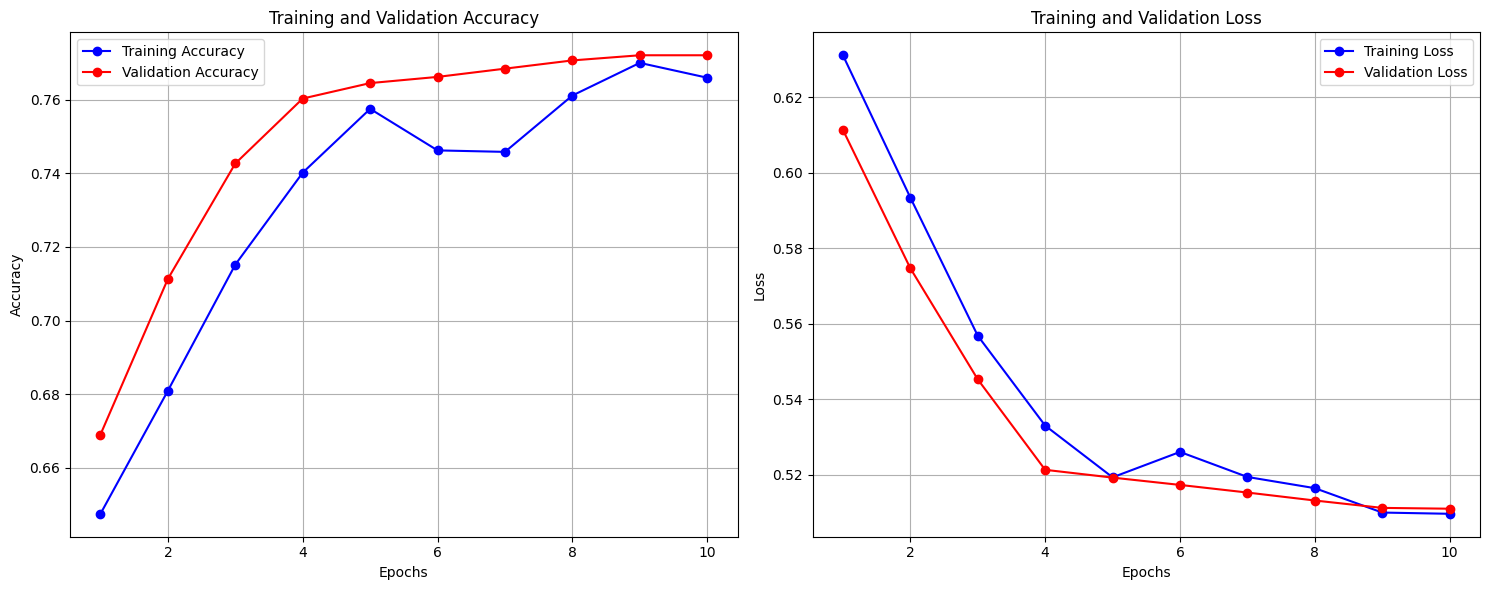

In [36]:
def plot_training_history(history):
    """Визуализация графикок обучения и валидации"""
    train_acc = history['train_acc']
    val_acc = history['val_acc']
    train_loss = history['train_loss']
    val_loss = history['val_loss']

    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(15, 6))

    # график Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # график лосса
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(training_history)

Модель обучалась 10 эпох.

Результаты - Стабильное снижение лосса и рост точности как на обучающей, так и на валидационной выборке, без явных признаков переобучения

Acc на валидации - 0.77

Что можно улучшить / добавить

1. Провести абляцию, добавляя / убирая новые агументации
2. Использовать предобученный CLIP для поиска и удаления наиболее явных ошибок разметки в исходном датасете
3.  После первоначального обучения "головы" можно разморозить несколько последних слоев трансформера и продолжить обучение с очень низким learning rate. Это может позволить модели точнее адаптироваться к специфике датасета.
4. Попробовать другие модели (Swin / CNN-модели)
5. Применить техники вроде Grad-CAM для визуализации областей, на которые модель обращает внимание. Это поможет убедиться, что модель фокусируется на самом Святом Георгии, а не на артефактах фона
6. Для получения более робастной и статистически значимой оценки производительности можно применить кросс-валидацию вместо простого разделения на train/val
7. Провести анализ изображений, где модель ошибается
8. Помимо перечисленных выыше улучшений, существует еще множество подходов, которые могут повысить качество / ускорить инференс модели